In [2]:
# Isaac Berez
# 17.01.23
import sys
from scipy.io import mmread
import os
import glob
import pandas as pd
import numpy as np
from pandas_ods_reader import read_ods
from copy import deepcopy
import pprint
import json
import re
from datetime import datetime
import logging
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn import preprocessing
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import harmonypy as hm
from matplotlib.cm import ScalarMappable
from datetime import date
import mpld3
import hvplot.pandas
import holoviews as hv
from holoviews import opts
import panel as pn
import bokeh
from bokeh.resources import INLINE

import dimorph_processing as dp

today = str(date.today())
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
status_df = dp.intialize_status_df()

# This notebook compares the amygdala data from Hochgerner et al.  (https://www.nature.com/articles/s41593-023-01469-3) to the sexual dimorphism data analyzed in both "dimorph_processing_nb.ipynb" (level1) and "dimorph_cell_analysis_nb.ipynb" (level2)

### Load data from Hochgerner et al.

In [ ]:
amy_df = pd.read_csv('/bigdata/isaac/amy_fc_data/Amy_FC_allcells_with_metadata_31-Jul-2022.txt', encoding='utf-8', delimiter='\t') 

In [118]:
amy_df.head()

,cellID,GGGTATTTCTCGCGTT-1_10-1,GGTAACTAGACATCCT-1_18-1,GGTAATCGTGGACTAG-1_18-1,TTCCGGTAGTGGTGGT-1_18-1,AGGGTGAAGTACAACA-1_19-1,AGTACCATCCCTGGTT-1_19-1,CATGAGTTCCGGCTTT-1_19-1,TTGCCTGAGACGGTTG-1_19-1,AAACGCTTCACCATGA-1_23-1,...,TCGAACAAGGAGCTGT-1_76-1,TGTACAGTCTGCAGCG-1_76-1,AGGACTTTCATGGAGG-1_76-2,CCCATTGGTACCTAGT-1_76-2,CTATCTACAATTGCTG-1_76-2,CTCATCGTCACCCATC-1_76-2,CTGCCATGTATCGCTA-1_76-2,GCATGATTCTCGTCGT-1_76-2,TGGGCGTAGAAGCCAC-1_76-2,TTCTGTAGTGGTATGG-1_76-2
0,celltype,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,...,pvm,pvm,pvm,pvm,pvm,pvm,pvm,pvm,pvm,pvm
1,sample,10-1,18-1,18-1,18-1,19-1,19-1,19-1,19-1,23-1,...,76-1,76-1,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2
2,FC time,2,2,2,2,2,2,2,2,0,...,2,2,2,2,2,2,2,2,2,2
3,batch,1,1,1,1,1,1,1,1,1,...,3,3,3,3,3,3,3,3,3,3
4,Xkr4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [119]:
type(amy_df.columns[1])

str

In [18]:
np.array(amy_df.iloc[:,1:2])

array([['GABA-11-Adora2a-Id4'],
       ['10-1'],
       ['2'],
       ...,
       [0],
       [0],
       [0]], dtype=object)

In [19]:
#save as feather for faster loading
#folder = '/bigdata/isaac/amy_fc_data/'
#amy_df = amy_df.astype(str)
#amy_df.to_feather(folder + 'amy_df.feather')

In [23]:
amy_df.columns

Index(['cellID', 'GGGTATTTCTCGCGTT-1_10-1', 'GGTAACTAGACATCCT-1_18-1',
       'GGTAATCGTGGACTAG-1_18-1', 'TTCCGGTAGTGGTGGT-1_18-1',
       'AGGGTGAAGTACAACA-1_19-1', 'AGTACCATCCCTGGTT-1_19-1',
       'CATGAGTTCCGGCTTT-1_19-1', 'TTGCCTGAGACGGTTG-1_19-1',
       'AAACGCTTCACCATGA-1_23-1',
       ...
       'TCGAACAAGGAGCTGT-1_76-1', 'TGTACAGTCTGCAGCG-1_76-1',
       'AGGACTTTCATGGAGG-1_76-2', 'CCCATTGGTACCTAGT-1_76-2',
       'CTATCTACAATTGCTG-1_76-2', 'CTCATCGTCACCCATC-1_76-2',
       'CTGCCATGTATCGCTA-1_76-2', 'GCATGATTCTCGTCGT-1_76-2',
       'TGGGCGTAGAAGCCAC-1_76-2', 'TTCTGTAGTGGTATGG-1_76-2'],
      dtype='object', length=55515)

In [120]:
amy_df = amy_df.set_index('cellID')

In [121]:
amy_df

,GGGTATTTCTCGCGTT-1_10-1,GGTAACTAGACATCCT-1_18-1,GGTAATCGTGGACTAG-1_18-1,TTCCGGTAGTGGTGGT-1_18-1,AGGGTGAAGTACAACA-1_19-1,AGTACCATCCCTGGTT-1_19-1,CATGAGTTCCGGCTTT-1_19-1,TTGCCTGAGACGGTTG-1_19-1,AAACGCTTCACCATGA-1_23-1,TACCCACCAGTGACCC-1_23-1,...,TCGAACAAGGAGCTGT-1_76-1,TGTACAGTCTGCAGCG-1_76-1,AGGACTTTCATGGAGG-1_76-2,CCCATTGGTACCTAGT-1_76-2,CTATCTACAATTGCTG-1_76-2,CTCATCGTCACCCATC-1_76-2,CTGCCATGTATCGCTA-1_76-2,GCATGATTCTCGTCGT-1_76-2,TGGGCGTAGAAGCCAC-1_76-2,TTCTGTAGTGGTATGG-1_76-2
cellID,,,,,,,,,,,,,,,,,,,,,
celltype,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,...,pvm,pvm,pvm,pvm,pvm,pvm,pvm,pvm,pvm,pvm
sample,10-1,18-1,18-1,18-1,19-1,19-1,19-1,19-1,23-1,23-1,...,76-1,76-1,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2
FC time,2,2,2,2,2,2,2,2,0,0,...,2,2,2,2,2,2,2,2,2,2
batch,1,1,1,1,1,1,1,1,1,1,...,3,3,3,3,3,3,3,3,3,3
Xkr4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC168977.1,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PISD,9,0,0,3,8,0,0,4,4,0,...,17,0,0,9,0,0,8,10,9,8
DHRSX,0,0,0,0,0,0,0,4,0,0,...,0,0,6,0,6,0,0,0,4,8


In [122]:
np.unique(np.array(amy_df.loc['celltype']))

array(['Astro', 'Astro_SC', 'Astro_agt', 'COP', 'EC', 'Epend',
       'GABA-1-Foxp2_Fmod', 'GABA-10-Prkcd-Adora2a',
       'GABA-11-Adora2a-Id4', 'GABA-12-Adora2a-Scn4b',
       'GABA-13-Adora2a-Crh', 'GABA-14-Drd1-Scn4b', 'GABA-15-Drd1-Ebf1',
       'GABA-16-Prkcd-Nts', 'GABA-17-Pdyn-Ebf1', 'GABA-18-Isl1-Tac1',
       'GABA-19-Isl1-Aldoc', 'GABA-2-Foxp2_Adra2a',
       'GABA-20-Gpr101-Gabre', 'GABA-21-Vdr-Nts', 'GABA-22-Gal-Avp',
       'GABA-23-Fign-Lrpprc', 'GABA-24-Fign-Ucn3', 'GABA-25-Lhx8-Th',
       'GABA-26-Cbln4-Sst', 'GABA-27-Lhx6-Nxph2', 'GABA-28-Cbln4-Luzp2',
       'GABA-29-Prlr-Greb1', 'GABA-3-Foxp2_Col6a1', 'GABA-30-Prlr-Calcr',
       'GABA-31-Prlr-Cbln1', 'GABA-32-Prlr-Tac1', 'GABA-33-Prlr-St18',
       'GABA-34-Prlr-Satb1', 'GABA-35-Chodl-Moxd1', 'GABA-36-Sst-Fign',
       'GABA-37-Sst-Npy', 'GABA-38-Sst-Tmtc4', 'GABA-39-Sst-Nek7',
       'GABA-4-Foxp2_Htr1f', 'GABA-40-Rpb4-Sst', 'GABA-41-Moxd1-Pvalb',
       'GABA-42-Moxd1-Vwc2', 'GABA-43-Crabp1-Etv1', 'GABA-44-Pthlh

### seperate out metadata

In [139]:
amy_metadata_df = amy_df.iloc[:4,:]

### add "cell_class" row to metadata

In [140]:
cls = [x.split('-')[0] for x in np.array(amy_metadata_df.loc['celltype'])]

In [141]:
np.unique(cls)

array(['Astro', 'Astro_SC', 'Astro_agt', 'COP', 'EC', 'Epend', 'GABA',
       'OL', 'OPC', 'OPC_cycling', 'Peri', 'VGLUT1', 'VGLUT2', 'VLMC',
       'VSM', 'microglia', 'pvm'], dtype='<U11')

In [142]:
amy_metadata_df.loc['cell_class'] = cls

/tmp/ipykernel_2941225/1827095788.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amy_metadata_df.loc['cell_class'] = cls


In [143]:
markers = [x.split('-')[2:4] for x in np.array(amy_metadata_df.loc['celltype'])]
markers

[['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 

In [144]:
amy_metadata_df.loc['markers'] = markers

/tmp/ipykernel_2941225/4262783576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amy_metadata_df.loc['markers'] = markers


### cell classes of interest: GABA, Vglut1, Vglut2, NN = microglia + epend + astro

In [286]:
amy_df.head()

,GGGTATTTCTCGCGTT-1_10-1,GGTAACTAGACATCCT-1_18-1,GGTAATCGTGGACTAG-1_18-1,TTCCGGTAGTGGTGGT-1_18-1,AGGGTGAAGTACAACA-1_19-1,AGTACCATCCCTGGTT-1_19-1,CATGAGTTCCGGCTTT-1_19-1,TTGCCTGAGACGGTTG-1_19-1,AAACGCTTCACCATGA-1_23-1,TACCCACCAGTGACCC-1_23-1,...,TCGAACAAGGAGCTGT-1_76-1,TGTACAGTCTGCAGCG-1_76-1,AGGACTTTCATGGAGG-1_76-2,CCCATTGGTACCTAGT-1_76-2,CTATCTACAATTGCTG-1_76-2,CTCATCGTCACCCATC-1_76-2,CTGCCATGTATCGCTA-1_76-2,GCATGATTCTCGTCGT-1_76-2,TGGGCGTAGAAGCCAC-1_76-2,TTCTGTAGTGGTATGG-1_76-2
cellID,,,,,,,,,,,,,,,,,,,,,
celltype,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,...,pvm,pvm,pvm,pvm,pvm,pvm,pvm,pvm,pvm,pvm
sample,10-1,18-1,18-1,18-1,19-1,19-1,19-1,19-1,23-1,23-1,...,76-1,76-1,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2
FC time,2,2,2,2,2,2,2,2,0,0,...,2,2,2,2,2,2,2,2,2,2
batch,1,1,1,1,1,1,1,1,1,1,...,3,3,3,3,3,3,3,3,3,3
Xkr4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [154]:
amy_df.loc['celltype'].index

Index(['GGGTATTTCTCGCGTT-1_10-1', 'GGTAACTAGACATCCT-1_18-1',
       'GGTAATCGTGGACTAG-1_18-1', 'TTCCGGTAGTGGTGGT-1_18-1',
       'AGGGTGAAGTACAACA-1_19-1', 'AGTACCATCCCTGGTT-1_19-1',
       'CATGAGTTCCGGCTTT-1_19-1', 'TTGCCTGAGACGGTTG-1_19-1',
       'AAACGCTTCACCATGA-1_23-1', 'TACCCACCAGTGACCC-1_23-1',
       ...
       'TCGAACAAGGAGCTGT-1_76-1', 'TGTACAGTCTGCAGCG-1_76-1',
       'AGGACTTTCATGGAGG-1_76-2', 'CCCATTGGTACCTAGT-1_76-2',
       'CTATCTACAATTGCTG-1_76-2', 'CTCATCGTCACCCATC-1_76-2',
       'CTGCCATGTATCGCTA-1_76-2', 'GCATGATTCTCGTCGT-1_76-2',
       'TGGGCGTAGAAGCCAC-1_76-2', 'TTCTGTAGTGGTATGG-1_76-2'],
      dtype='object', length=55514)

### isolate gaba columns

In [149]:
gaba_cols = [c for c,x in zip(amy_df.loc['celltype'].index,np.array(amy_df.loc['celltype'])) if 'GABA' in x]

In [150]:
amy_df_gaba = amy_df.loc[:,gaba_cols]

In [151]:
amy_df_gaba_expr = amy_df_gaba.iloc[4:,:]

In [152]:
amy_df_gaba

,GGGTATTTCTCGCGTT-1_10-1,GGTAACTAGACATCCT-1_18-1,GGTAATCGTGGACTAG-1_18-1,TTCCGGTAGTGGTGGT-1_18-1,AGGGTGAAGTACAACA-1_19-1,AGTACCATCCCTGGTT-1_19-1,CATGAGTTCCGGCTTT-1_19-1,TTGCCTGAGACGGTTG-1_19-1,AAACGCTTCACCATGA-1_23-1,TACCCACCAGTGACCC-1_23-1,...,GTCAAACTCCCGATCT-1_76-2,GTGTAACGTGAGACCA-1_76-2,GTGTGATAGGTGAGAA-1_76-2,TACTTCAGTAACTAAG-1_76-2,TCCGATCTCGTTTACT-1_76-2,TCGCTCAAGATTGAGT-1_76-2,TGCAGGCTCTTACACT-1_76-2,TTACAGGTCCGAGATT-1_76-2,TTGCGTCCAACACGAG-1_76-2,TTGCTGCAGCACTCCG-1_76-2
cellID,,,,,,,,,,,,,,,,,,,,,
celltype,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,...,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh
sample,10-1,18-1,18-1,18-1,19-1,19-1,19-1,19-1,23-1,23-1,...,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2
FC time,2,2,2,2,2,2,2,2,0,0,...,2,2,2,2,2,2,2,2,2,2
batch,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
Xkr4,0,0,0,0,0,0,0,0,0,0,...,7,0,6,0,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC168977.1,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PISD,9,0,0,3,8,0,0,4,4,0,...,0,0,0,0,0,3,0,2,2,0
DHRSX,0,0,0,0,0,0,0,4,0,0,...,0,3,0,0,0,0,0,0,0,0


In [153]:
amy_metadata_df_gaba = amy_metadata_df.loc[:,gaba_cols]

### add "cluster_label" row to metadata

In [594]:
amy_gaba_cluster_labels = np.array(amy_metadata_df_gaba.loc['celltype'].apply(lambda x: int(re.search(r'-(\d+)-', x).group(1))))

In [599]:
np.unique(amy_gaba_cluster_labels)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56])

In [596]:
amy_metadata_df_gaba.loc['cluster_label'] = amy_gaba_cluster_labels

In [597]:
amy_metadata_df_gaba

,GGGTATTTCTCGCGTT-1_10-1,GGTAACTAGACATCCT-1_18-1,GGTAATCGTGGACTAG-1_18-1,TTCCGGTAGTGGTGGT-1_18-1,AGGGTGAAGTACAACA-1_19-1,AGTACCATCCCTGGTT-1_19-1,CATGAGTTCCGGCTTT-1_19-1,TTGCCTGAGACGGTTG-1_19-1,AAACGCTTCACCATGA-1_23-1,TACCCACCAGTGACCC-1_23-1,...,GTCAAACTCCCGATCT-1_76-2,GTGTAACGTGAGACCA-1_76-2,GTGTGATAGGTGAGAA-1_76-2,TACTTCAGTAACTAAG-1_76-2,TCCGATCTCGTTTACT-1_76-2,TCGCTCAAGATTGAGT-1_76-2,TGCAGGCTCTTACACT-1_76-2,TTACAGGTCCGAGATT-1_76-2,TTGCGTCCAACACGAG-1_76-2,TTGCTGCAGCACTCCG-1_76-2
cellID,,,,,,,,,,,,,,,,,,,,,
celltype,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,...,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh
sample,10-1,18-1,18-1,18-1,19-1,19-1,19-1,19-1,23-1,23-1,...,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2
FC time,2,2,2,2,2,2,2,2,0,0,...,2,2,2,2,2,2,2,2,2,2
batch,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
cell_class,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,...,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA
cluster_label,11,11,11,11,11,11,11,11,11,11,...,51,51,51,51,51,51,51,51,51,51


In [568]:
amy_df_gaba_expr.shape

(27998, 13006)

In [176]:
amy_df_gaba_expr.head()

,GGGTATTTCTCGCGTT-1_10-1,GGTAACTAGACATCCT-1_18-1,GGTAATCGTGGACTAG-1_18-1,TTCCGGTAGTGGTGGT-1_18-1,AGGGTGAAGTACAACA-1_19-1,AGTACCATCCCTGGTT-1_19-1,CATGAGTTCCGGCTTT-1_19-1,TTGCCTGAGACGGTTG-1_19-1,AAACGCTTCACCATGA-1_23-1,TACCCACCAGTGACCC-1_23-1,...,GTCAAACTCCCGATCT-1_76-2,GTGTAACGTGAGACCA-1_76-2,GTGTGATAGGTGAGAA-1_76-2,TACTTCAGTAACTAAG-1_76-2,TCCGATCTCGTTTACT-1_76-2,TCGCTCAAGATTGAGT-1_76-2,TGCAGGCTCTTACACT-1_76-2,TTACAGGTCCGAGATT-1_76-2,TTGCGTCCAACACGAG-1_76-2,TTGCTGCAGCACTCCG-1_76-2
cellID,,,,,,,,,,,,,,,,,,,,,
Xkr4,0,0,0,0,0,0,0,0,0,0,...,7,0,6,0,0,0,2,0,0,0
Gm1992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm37381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rp1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rp1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Remove duplicate gene rows

In [569]:
amy_df_gaba_expr = amy_df_gaba_expr[~amy_df_gaba_expr.index.duplicated(keep='first')]

In [570]:
amy_df_gaba_expr.shape

(27933, 13006)

### remove IEG genes

In [571]:
IEG_list = []

with open('/bigdata/isaac/IEG_cluster.txt', 'r') as fh:
    for g in fh:
        IEG_list.append(g[:-1])

In [572]:
amy_df_gaba_expr = dp.gene_remover(IEG_list, amy_df_gaba_expr)

removing  53  genes found in  ['Btg2', 'Jun', 'Egr4', 'Fosb', 'Junb', 'Gadd45g', 'Fos', 'Arc', 'Nr4a1', 'Npas4', 'Coq10b', 'Tns1', 'Per2', 'Ptgs2', 'Rnd3', 'Tnfaip6', 'Srxn1', 'Tiparp', 'Ccnl1', 'Mcl1', 'Dnajb5', 'Nr4a3', 'Fosl2', 'Nptx2', 'Rasl11a', 'Mest', 'Sertad1', 'Egr2', 'Midn', 'Gadd45b', 'Dusp6', 'Irs2', 'Plat', 'Ier2', 'Rrad', 'Tpbg', 'Csrnp1', 'Peli1', 'Per1', 'Kdm6b', 'Inhba', 'Plk2', 'Ifrd1', 'Baz1a', 'Trib1', 'Pim3', 'Lrrk2', 'Dusp1', 'Cdkn1a', 'Pim1', 'Sik1', 'Frat2', 'Dusp5']


In [505]:
amy_df_gaba_expr.shape

(27880, 13006)

In [514]:
#ensure all values are integers
amy_df_gaba_expr = amy_df_gaba_expr.astype('int')

### Perform gene exclusion + feature selection to get high variable genes of interest for amy data

In [515]:
amy_df_gaba_bool = amy_df_gaba_expr.mask(amy_df_gaba_expr>0, other = 1)

In [518]:
amy_df_gaba_expr

,GGGTATTTCTCGCGTT-1_10-1,GGTAACTAGACATCCT-1_18-1,GGTAATCGTGGACTAG-1_18-1,TTCCGGTAGTGGTGGT-1_18-1,AGGGTGAAGTACAACA-1_19-1,AGTACCATCCCTGGTT-1_19-1,CATGAGTTCCGGCTTT-1_19-1,TTGCCTGAGACGGTTG-1_19-1,AAACGCTTCACCATGA-1_23-1,TACCCACCAGTGACCC-1_23-1,...,GTCAAACTCCCGATCT-1_76-2,GTGTAACGTGAGACCA-1_76-2,GTGTGATAGGTGAGAA-1_76-2,TACTTCAGTAACTAAG-1_76-2,TCCGATCTCGTTTACT-1_76-2,TCGCTCAAGATTGAGT-1_76-2,TGCAGGCTCTTACACT-1_76-2,TTACAGGTCCGAGATT-1_76-2,TTGCGTCCAACACGAG-1_76-2,TTGCTGCAGCACTCCG-1_76-2
cellID,,,,,,,,,,,,,,,,,,,,,
Xkr4,0,0,0,0,0,0,0,0,0,0,...,7,0,6,0,0,0,2,0,0,0
Gm1992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm37381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rp1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sox17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC168977.1,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PISD,9,0,0,3,8,0,0,4,4,0,...,0,0,0,0,0,3,0,2,2,0
DHRSX,0,0,0,0,0,0,0,4,0,0,...,0,3,0,0,0,0,0,0,0,0


In [519]:
amy_df_gaba_expr_ge, amy_df_gaba_bool, amy_metadata_df_gaba, status_df = dp.gene_exclusion(num_cell_lwr_bound=10,
                                                      percent_cell_upper_bound=50,
                                                     df_bool=amy_df_gaba_bool,
                                                     df = amy_df_gaba_expr,
                                                     meta_data_df = amy_metadata_df_gaba,
                                                     status_df = status_df)

Total genes reduced from 27880 to 14303


In [521]:
amy_df_gaba_expr_ge.shape

(14303, 13006)

<IPython.core.display.Javascript object>


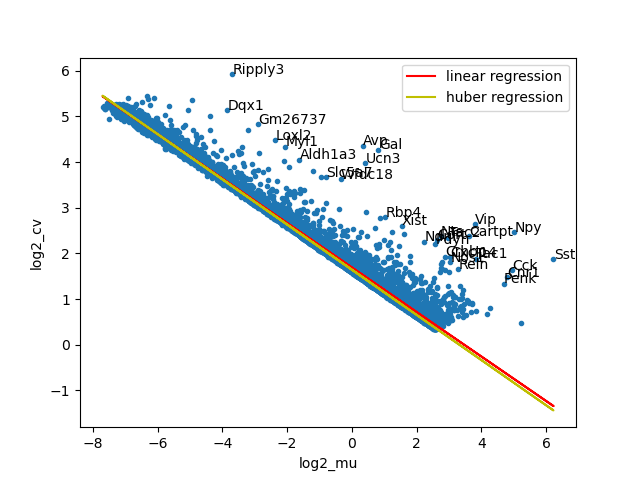

In [520]:
amy_gaba_cv_df = dp.analyze_cv(df = amy_df_gaba_expr_ge,
                      norm_scale_factor=20000,
                      num_top_genes=30,
                      plot_flag=1,
                     use_huber = True)

<IPython.core.display.Javascript object>


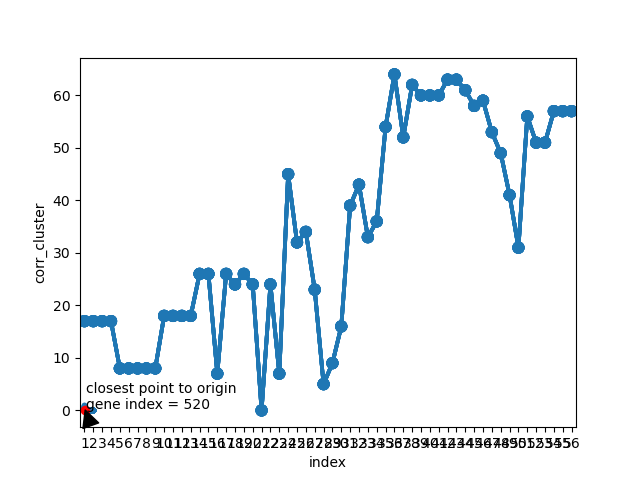

In [522]:
amy_gaba_gene_index, amy_df_gaba_expr_ge_cv, status_df = dp.get_top_cv_genes(df = amy_df_gaba_expr_ge, cv_df=amy_gaba_cv_df, plot_flag=1, status_df=status_df)

### Load gaba_df_prelinkage_ls saved from "dimorph_cell_analysis_nb.ipynb"
### already has feature selected genes

In [4]:
#gaba_df_marker = pd.read_feather('/bigdata/isaac/gaba_files/gaba_df_marker_2024-06-07.feather')
gaba_meta_data_df_plis = pd.read_json('/bigdata/isaac/gaba_files/gaba_meta_data_df_plis2024-06-07.json')

#gaba_df_prelinkage_ls = pd.read_feather('/bigdata/isaac/gaba_files/gaba_df_pre_linkage_ls_2024-06-04.feather')
#meta_data_df_prelinkage_ls = pd.read_json('/bigdata/isaac/gaba_files/gaba_meta_data_df_pre_linkage_2024-06-04.json')


In [5]:
lco = pd.unique(gaba_meta_data_df_plis.loc['cluster_label'])
lco

array([31, 12, 42, 43, 40, 39, 36, 55, 65, 33, 16, 38, 2, 20, 35, 0, 14,
       4, 5, 3, 15, 11, 10, 6, 21, 41, 37, 25, 18, 26, 22, 27, 24, 28, 8,
       7, 19, 17, 44, 46, 45, 9, 47, 50, 23, 1, 13, 29, 30, 32, 56, 51,
       57, 53, 48, 49, 59, 58, 61, 60, 63, 62, 54, 34, 64, 52],
      dtype=object)

In [662]:
pd.unique(meta_data_df_prelinkage_ls.loc['cluster_label'])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65], dtype=object)

In [993]:
gaba_df_prelinkage_ls = gaba_df_prelinkage_ls.T

In [994]:
gaba_df_prelinkage_ls.shape

(559, 13529)

In [995]:
gaba_df_prelinkage_ls.head()

,CCGGGTAGTGTTGAGG-1_10X51_3,TCTAACTAGTGGCCTC-1_10X36_1,CTATCCGGTAAGGTCG-1_10X51_2,AGCGATTGTGTCTAAC-1_10X52_1,TCGGATAGTAGGAAAG-1_10X37_1,TTACGTTGTATCAAGA-1_10X37_2,GGGCGTTAGCGTATAA-1_10X51_1,TAGACCACAGTCCGTG-1_10X51_1,CTACTATAGCCTGAGA-1_10X38_1,TCACGGGGTATCACGT-1_10X38_1,...,TTGAGTGTCAGTGCGC-1_10X36_1,CGCAGGTCATCGATGT-1_10X37_1,ATCGTAGAGAAGCTCG-1_10X52_2,GCAGCTGGTGTGTCCG-1_10X52_3,CATACCCCAGTTTCGA-1_10X52_1,ACCCAAAAGCATTGAA-1_10X38_1,CAGCGTGAGCCACAAG-1_10X51_2,AATTCCTGTGAATTAG-1_10X51_1,GACCTTCGTATGAGGC-1_10X38_1,GTCTTTACAGGTCCGT-1_10X37_1
gene,,,,,,,,,,,,,,,,,,,,,
Avp,-0.201913,-0.201913,2.945428,-0.201913,-0.201913,-0.201913,-0.201913,-0.201913,-0.201913,-0.201913,...,-0.201913,-0.201913,-0.201913,-0.201913,-0.201913,-0.201913,-0.201913,-0.201913,-0.201913,-0.201913
Vip,-0.154338,-0.154338,-0.154338,-0.154338,-0.154338,-0.154338,-0.154338,-0.154338,-0.154338,-0.154338,...,-0.154338,-0.154338,-0.154338,-0.154338,-0.154338,-0.154338,-0.154338,-0.154338,-0.154338,-0.154338
Sst,-0.395937,-0.395937,1.929167,1.804529,2.318293,-0.395937,1.929167,2.774148,-0.395937,-0.395937,...,1.663226,1.929167,1.929167,2.318293,2.233592,2.825778,2.396714,2.040659,1.929167,-0.395937
Cartpt,-0.487214,-0.487214,-0.487214,-0.487214,-0.487214,-0.487214,-0.487214,-0.487214,-0.487214,-0.487214,...,0.178540,-0.487214,-0.487214,-0.487214,-0.487214,-0.487214,-0.487214,-0.487214,-0.487214,-0.487214
Ucn3,-0.158813,-0.158813,-0.158813,-0.158813,-0.158813,-0.158813,-0.158813,-0.158813,1.443596,-0.158813,...,-0.158813,-0.158813,-0.158813,-0.158813,-0.158813,-0.158813,-0.158813,-0.158813,-0.158813,-0.158813


In [996]:
meta_data_df_prelinkage_ls.tail()

,CCGGGTAGTGTTGAGG-1_10X51_3,TCTAACTAGTGGCCTC-1_10X36_1,CTATCCGGTAAGGTCG-1_10X51_2,AGCGATTGTGTCTAAC-1_10X52_1,TCGGATAGTAGGAAAG-1_10X37_1,TTACGTTGTATCAAGA-1_10X37_2,GGGCGTTAGCGTATAA-1_10X51_1,TAGACCACAGTCCGTG-1_10X51_1,CTACTATAGCCTGAGA-1_10X38_1,TCACGGGGTATCACGT-1_10X38_1,...,TTGAGTGTCAGTGCGC-1_10X36_1,CGCAGGTCATCGATGT-1_10X37_1,ATCGTAGAGAAGCTCG-1_10X52_2,GCAGCTGGTGTGTCCG-1_10X52_3,CATACCCCAGTTTCGA-1_10X52_1,ACCCAAAAGCATTGAA-1_10X38_1,CAGCGTGAGCCACAAG-1_10X51_2,AATTCCTGTGAATTAG-1_10X51_1,GACCTTCGTATGAGGC-1_10X38_1,GTCTTTACAGGTCCGT-1_10X37_1
ngperul_seqlib,22.0,11.4,22.2,15.7,15.9,16.0,19.2,19.2,15.0,15.0,...,11.4,15.9,17.5,20.4(second prep),15.7,15.0,22.2,19.2,15.0,15.9
lengthbp_seqlib,487.0,476.0,474.0,466.0,440.0,460.0,478.0,478.0,420.0,420.0,...,476.0,440.0,440.0,507.0,466.0,420.0,474.0,478.0,420.0,440.0
Sample_Index,B2,H8,A2,D12,E9,F9,G1,G1,B9,B9,...,H8,E9,E12,F12,D12,B9,A2,G1,B9,E9
cell_class,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,...,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA
cluster_label,0,0,0,0,0,0,0,0,0,0,...,65,65,65,65,65,65,65,65,65,65


### Get Gene index shared by both datasets, then isolate only these genes from each

In [997]:
amy_df_gaba_expr_ge_cv.index

Index(['Sst', 'Npy', 'Gal', 'Avp', 'Vip', 'Ucn3', 'Cartpt', 'Ripply3', 'Cck',
       'Cnr1',
       ...
       'Nbl1', 'Jsrp1', 'Sostdc1', 'Shisa6', 'Fam19a2', 'Pdlim5', 'Ppargc1a',
       'Pld5', 'Kcnip4', 'Lhfp'],
      dtype='object', length=378)

In [998]:
gaba_df_prelinkage_ls.index

Index(['Avp', 'Vip', 'Sst', 'Cartpt', 'Ucn3', 'Nts', 'Gal', 'Cck', 'Npy',
       'Cort',
       ...
       'Tox', 'Pgr15l', 'Pex5l', 'Sema6d', 'Igsf1', 'Glra2', 'Dpy19l1',
       'Anxa2', 'Rnase4', 'Etv4'],
      dtype='object', name='gene', length=559)

In [528]:
#change to union?
intersected_gene_ind = amy_df_gaba_expr_ge_cv.index.intersection(gaba_df_prelinkage_ls.index)
intersected_gene_ind

Index(['Sst', 'Npy', 'Gal', 'Avp', 'Vip', 'Ucn3', 'Cartpt', 'Ripply3', 'Cck',
       'Cnr1',
       ...
       'Nbl1', 'Jsrp1', 'Sostdc1', 'Shisa6', 'Fam19a2', 'Pdlim5', 'Ppargc1a',
       'Pld5', 'Kcnip4', 'Lhfp'],
      dtype='object', length=378)

In [999]:
amy_df_gaba_expr_ge_cv = amy_df_gaba_expr_ge_cv.reindex(index = intersected_gene_ind)
gaba_df_prelinkage_ls = gaba_df_prelinkage_ls.reindex(index = intersected_gene_ind)

In [530]:
amy_df_gaba_expr_ge_cv.shape

(378, 13006)

In [1005]:
gaba_df_prelinkage_ls.shape

(378, 13529)

### log and standerdize amy_df_gaba_expr to match gaba_df_prelinkage_ls

In [534]:
amy_arr_gaba_expr_ge_cv_ls,status_df = dp.log_and_standerdize_df(amy_df_gaba_expr_ge_cv,status_df)

column (gene) mean after standardization: -0.00
column (gene) sigma after standardization: 1.00


In [536]:
#put outputted log/standerdized array back into dataframe format
amy_arr_gaba_expr_ge_cv_ls = pd.DataFrame(data=amy_arr_gaba_expr_ge_cv_ls.T, index=amy_df_gaba_expr_ge_cv.index, columns=amy_df_gaba_expr_ge_cv.columns)

In [537]:
amy_arr_gaba_expr_ge_cv_ls.shape

(378, 13006)

In [1002]:
amy_arr_gaba_expr_ge_cv_ls.head()

,GGGTATTTCTCGCGTT-1_10-1,GGTAACTAGACATCCT-1_18-1,GGTAATCGTGGACTAG-1_18-1,TTCCGGTAGTGGTGGT-1_18-1,AGGGTGAAGTACAACA-1_19-1,AGTACCATCCCTGGTT-1_19-1,CATGAGTTCCGGCTTT-1_19-1,TTGCCTGAGACGGTTG-1_19-1,AAACGCTTCACCATGA-1_23-1,TACCCACCAGTGACCC-1_23-1,...,GTCAAACTCCCGATCT-1_76-2,GTGTAACGTGAGACCA-1_76-2,GTGTGATAGGTGAGAA-1_76-2,TACTTCAGTAACTAAG-1_76-2,TCCGATCTCGTTTACT-1_76-2,TCGCTCAAGATTGAGT-1_76-2,TGCAGGCTCTTACACT-1_76-2,TTACAGGTCCGAGATT-1_76-2,TTGCGTCCAACACGAG-1_76-2,TTGCTGCAGCACTCCG-1_76-2
Sst,-0.545385,0.306249,-0.545385,-0.545385,-0.545385,-0.545385,-0.545385,1.157884,-0.545385,0.443332,...,-0.545385,-0.545385,-0.545385,-0.545385,-0.545385,-0.545385,-0.545385,-0.545385,-0.545385,-0.545385
Npy,1.105514,-0.442248,-0.442248,-0.442248,-0.442248,-0.442248,-0.442248,-0.442248,-0.442248,-0.442248,...,-0.442248,-0.442248,-0.442248,-0.442248,-0.442248,-0.442248,-0.442248,-0.442248,-0.442248,-0.442248
Gal,-0.112651,-0.112651,-0.112651,-0.112651,-0.112651,-0.112651,-0.112651,-0.112651,-0.112651,-0.112651,...,-0.112651,-0.112651,-0.112651,-0.112651,-0.112651,-0.112651,-0.112651,-0.112651,-0.112651,-0.112651
Avp,-0.108845,-0.108845,-0.108845,-0.108845,-0.108845,-0.108845,-0.108845,-0.108845,-0.108845,-0.108845,...,-0.108845,-0.108845,-0.108845,-0.108845,-0.108845,-0.108845,-0.108845,-0.108845,-0.108845,-0.108845
Vip,-0.222700,-0.222700,-0.222700,-0.222700,-0.222700,-0.222700,-0.222700,-0.222700,-0.222700,-0.222700,...,4.745730,5.499811,5.231021,4.307494,5.422867,4.210936,5.386956,5.816290,5.602638,5.026132


### Checkpoint - save intersected data/metadata to file / load from here

In [1006]:
#save to file

#folder = '/bigdata/isaac/gaba_files/'

#file1 = 'amy_arr_gaba_expr_ge_cv_ls_cell_comp' 
#file2 = 'amy_metadata_df_gaba_cell_comp' 

#amy_arr_gaba_expr_ge_cv_ls.to_feather(folder+file1+'.feather')
#amy_metadata_df_gaba.to_json(folder+file2+'.json')

#################################

#file1 = 'gaba_df_prelinkage_ls_cell_comp' 
#file2 = 'gaba_meta_data_df_prelinkage_cell_comp' 

#gaba_df_prelinkage_ls.to_feather(folder+file1+'.feather')
#gaba_meta_data_df_pre_linkage.to_json(folder+file2+'.json')


In [7]:
#load data
folder = '/bigdata/isaac/gaba_files/'

amy_arr_gaba_expr_ge_cv_ls = pd.read_feather(folder + 'amy_arr_gaba_expr_ge_cv_ls_cell_comp.feather')
amy_metadata_df_gaba = pd.read_json(folder + 'amy_metadata_df_gaba_cell_comp.json')

gaba_df_prelinkage_ls = pd.read_feather(folder + 'gaba_df_prelinkage_ls_cell_comp.feather')
gaba_meta_data_df_prelinkage = pd.read_json(folder + 'gaba_meta_data_df_prelinkage_cell_comp.json' )

### Compute avg expression for all genes, for every cluster

In [8]:
amy_avgs = dp.compute_avg_expr_per_cluster_label(amy_arr_gaba_expr_ge_cv_ls,amy_metadata_df_gaba)

In [9]:
amy_avgs

,1,2,3,4,5,6,7,8,9,10,...,47,48,49,50,51,52,53,54,55,56
Sst,-0.155349,-0.280595,-0.455989,-0.492804,-0.148882,-0.314029,0.423542,-0.263417,-0.395131,-0.501013,...,0.155029,-0.447587,-0.450272,-0.514228,-0.427441,-0.440583,-0.451893,-0.427688,-0.345629,-0.444237
Npy,-0.359158,-0.22505,0.068509,0.900939,-0.086038,-0.150077,-0.38883,-0.387799,-0.364963,-0.282428,...,-0.333043,-0.372397,-0.366435,-0.401907,-0.352834,-0.374402,-0.396366,-0.403158,-0.264757,-0.154209
Gal,-0.112651,-0.112651,-0.089581,-0.112651,-0.074812,-0.069099,-0.112651,-0.087391,-0.068467,-0.112651,...,-0.097408,-0.105911,-0.050846,0.248763,-0.100601,-0.041433,-0.112651,-0.112651,-0.112651,-0.0807
Avp,-0.108845,-0.071297,-0.028345,-0.108845,-0.052378,-0.021984,-0.073287,-0.055146,-0.05929,-0.052248,...,-0.086099,-0.053048,0.014219,0.012632,0.005873,-0.026616,-0.08045,-0.026667,-0.108845,-0.067684
Vip,-0.211028,-0.20211,-0.196752,-0.158658,-0.172872,-0.205202,-0.204007,-0.19946,-0.199775,-0.193786,...,-0.172384,-0.192407,-0.048683,2.22628,4.872482,-0.2227,-0.116881,0.244626,3.712796,-0.111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pdlim5,-0.213751,0.238679,-0.262204,-0.221797,-0.258688,-0.112715,-0.231641,-0.040965,0.636983,-0.275033,...,-0.089209,-0.245919,-0.256575,-0.021224,0.016749,-0.197397,-0.220275,-0.12304,-0.148883,0.892313
Ppargc1a,0.367969,-0.343563,-0.508327,-0.56609,-0.381029,-0.377084,-0.113144,-0.000711,0.085683,0.054693,...,0.26656,0.462964,0.207191,-0.251954,-0.049666,-0.366242,-0.364607,-0.226413,-0.300026,-0.28419
Pld5,0.36542,0.951358,-0.240701,-0.005046,0.487558,0.130078,0.07014,-0.385895,-0.406659,-0.206469,...,-0.077231,-0.328914,0.729462,0.605465,-0.204186,-0.336766,-0.136654,-0.280694,-0.142431,-0.358911
Kcnip4,0.535392,0.517315,0.247973,0.685572,0.714297,0.258686,-0.060652,-0.047448,0.049714,0.321894,...,-0.681736,0.666536,0.522226,-0.083875,0.150193,-0.050973,-0.617036,0.345685,0.713779,-0.487957


In [11]:
sd_avgs = dp.compute_avg_expr_per_cluster_label(gaba_df_prelinkage_ls,gaba_meta_data_df_prelinkage)

In [12]:
sd_avgs

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
Sst,-0.052799,-0.335815,-0.350333,-0.355693,-0.383913,-0.355985,-0.340964,-0.19556,-0.265766,-0.236357,...,-0.345609,-0.358898,-0.361009,-0.373029,0.168473,-0.35041,3.078125,-0.03385,3.957141,1.575562
Npy,-0.283375,-0.266134,-0.274041,-0.277158,-0.251861,-0.277019,-0.264008,-0.249343,-0.260414,-0.258252,...,-0.254232,-0.279362,-0.083082,0.189093,0.126427,-0.287002,3.211631,0.065238,3.251905,1.751706
Gal,-0.126186,-0.074353,0.206326,-0.121254,-0.126186,-0.126186,-0.115208,-0.086827,-0.126186,-0.037761,...,-0.126186,-0.126186,-0.126186,-0.126186,-0.105983,-0.126186,-0.091943,-0.126186,-0.126186,-0.126186
Avp,0.125462,-0.006238,-0.049596,0.012925,-0.072924,0.011349,0.023045,-0.097437,0.052388,0.03684,...,-0.093788,0.046217,-0.201913,-0.02162,-0.085422,-0.071679,-0.099653,-0.047967,-0.201913,0.04019
Vip,-0.140506,-0.154338,-0.154338,-0.141714,-0.154338,-0.146863,-0.148718,-0.143694,-0.148833,-0.150188,...,6.180234,0.292554,-0.128649,-0.138424,-0.143997,-0.154338,-0.148495,-0.154338,-0.154338,-0.154338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pdlim5,-0.11998,-0.189726,-0.149567,-0.18336,-0.089394,-0.17088,-0.161391,-0.155866,-0.056705,-0.147878,...,0.067439,0.64145,1.137411,2.250012,-0.150619,-0.161587,-0.160266,-0.145376,0.050282,-0.189726
Ppargc1a,0.235094,0.649442,-0.308002,0.18521,-0.250753,-0.095112,-0.21442,-0.241566,-0.379606,0.034571,...,-0.370182,-0.106719,-0.106876,-0.580984,1.162206,1.274981,0.27052,0.336414,0.719777,-0.197765
Pld5,-0.278213,-0.290832,-0.170091,-0.381998,0.077507,0.216949,0.506481,0.246273,0.035793,-0.234992,...,-0.230746,-0.386371,0.332568,0.861317,-0.348903,-0.39976,-0.222383,-0.267581,-0.313061,-0.352265
Kcnip4,0.348098,-0.235703,-0.318286,0.679367,-0.318462,0.103619,0.194134,0.035256,0.159885,0.24254,...,-0.105421,-0.326052,-0.788783,-0.521333,-0.664137,-0.800358,-0.669239,-0.630478,0.099243,-0.284288


### Compute pearson correlation coeffcient for every column between avg expr datasets

corr_matrix_manual = dim(sd_avgs x amy_avgs)

In [13]:
# Initialize an empty dataframe to hold the correlation coefficients
corr_matrix_manual = pd.DataFrame(index=sd_avgs.columns, columns=amy_avgs.columns)

# Compute the correlation coefficients
for col1 in sd_avgs.columns:
    for col2 in amy_avgs.columns:
        corr_matrix_manual.loc[col1, col2] = sd_avgs[col1].corr(amy_avgs[col2])

In [14]:
corr_matrix_manual.shape

(66, 56)

In [15]:
corr_matrix_manual

,1,2,3,4,5,6,7,8,9,10,...,47,48,49,50,51,52,53,54,55,56
0,-0.01201,0.020433,0.06362,-0.02082,0.000904,0.027228,0.034012,-0.06181,0.142248,0.164479,...,0.04024,0.159923,-0.092633,-0.031112,-0.052816,-0.112296,-0.084936,-0.113639,-0.106715,-0.086127
1,0.08766,-0.039294,-0.034626,-0.013889,-0.004004,-0.069779,0.044852,0.064597,-0.0973,-0.034907,...,0.047653,0.152267,0.005393,-0.017404,-0.110333,-0.10663,-0.077786,-0.035559,-0.04132,0.005037
2,0.084488,0.032233,0.093602,0.166215,0.187083,0.114193,0.165848,0.172464,0.054936,0.028032,...,-0.245826,-0.215955,-0.11534,-0.009132,-0.198511,-0.267668,-0.196831,-0.220429,-0.166209,-0.118693
3,0.175915,0.19637,0.155996,0.099051,0.128262,0.006573,0.079272,0.061207,0.151743,0.176193,...,-0.003676,0.629394,0.083292,-0.046276,-0.101233,-0.02545,-0.022972,-0.059853,-0.065599,-0.082605
4,0.051464,0.081996,0.149322,0.24157,0.41849,0.237807,0.35341,0.281377,0.224841,0.186672,...,-0.165283,0.03575,0.024819,-0.019976,-0.117015,-0.139005,-0.126627,-0.155594,-0.149778,-0.129659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,-0.104907,-0.137763,-0.173484,-0.163342,-0.263405,-0.211678,-0.229007,-0.167774,-0.131576,-0.111821,...,0.087417,-0.072357,-0.092484,-0.013462,0.050144,-0.028618,0.00802,0.012118,0.033511,0.04108
62,-0.101302,-0.171687,-0.226034,-0.195269,-0.288026,-0.229857,-0.188199,-0.187155,-0.162989,-0.174742,...,0.128739,-0.094751,-0.073041,-0.059805,0.006234,-0.014712,0.033338,-0.026364,-0.054414,-0.021657
63,-0.059025,-0.187182,-0.280098,-0.283435,-0.349985,-0.302309,-0.282447,-0.196692,-0.133033,-0.16159,...,0.095116,-0.058105,0.02356,-0.018006,0.086695,0.090782,0.01142,-0.000663,-0.017045,-0.025021
64,-0.054707,-0.126893,-0.159199,-0.112919,-0.173601,-0.170755,-0.109088,-0.101524,-0.132849,-0.13749,...,0.054623,-0.073408,0.016512,-0.063889,-0.094688,-0.053171,-0.042992,-0.081869,-0.065134,-0.043778


In [16]:
# Calculate the 2nd and 98th percentiles for robust scaling (mimicing seaborn's robust = TRUE)
#vmin, vmax = np.percentile(corr_matrix_manual.values, [2, 98])

# Create the heatmap
heatmap = corr_matrix_manual.hvplot.heatmap( cmap='viridis', width=900, height=900, colorbar=True)
# Display the plot
hvplot.show(heatmap)
    
# Ensure output is displayed inline
hv.output(heatmap, backend='bokeh')

Launching server at http://localhost:35261


:HeatMap   [columns,index]   (value)

In [17]:
#take argmax of every row of corr_matrix_manual, store in seperate dataframe, then resort corr_matrix_manual rows by ascending arg_max values
heatmap_argmax_df = pd.DataFrame(columns = ['argmax','max'], index=corr_matrix_manual.index)
for i in corr_matrix_manual.index:
    heatmap_argmax_df.iloc[i,:] = (np.argmax(corr_matrix_manual.loc[i,:]),np.max(corr_matrix_manual.loc[i,:]))
heatmap_argmax_df.sort_values(by = 'argmax')
corr_matrix_manual_sorted = corr_matrix_manual.reindex(index = heatmap_argmax_df.sort_values(by = 'argmax').index)

In [18]:
corr_matrix_manual_sorted.index

Index([17, 19, 44,  4,  6, 25, 18,  8, 46, 22, 28, 26, 15, 14,  0, 24, 11,  7,
       10, 30, 45, 27, 32, 34, 23,  1, 35, 47, 29, 50, 13,  5, 20,  2, 38,  9,
       16, 39, 43, 12, 40, 42, 55, 65, 33, 36, 54, 64, 52, 62, 60, 63, 61, 58,
       59, 53,  3, 49, 48, 37, 41, 21, 31, 56, 51, 57],
      dtype='object')

In [19]:
corr_matrix_manual_sorted

,1,2,3,4,5,6,7,8,9,10,...,47,48,49,50,51,52,53,54,55,56
17,0.454419,0.832672,0.803021,0.748034,0.371633,0.192474,0.187261,0.080278,0.105659,0.17905,...,-0.163907,-0.114661,-0.113758,-0.077285,-0.193746,-0.200553,-0.142442,-0.22069,-0.172419,-0.162796
19,0.150352,0.167306,0.347238,0.241095,0.191112,0.201605,0.111167,0.102905,0.084646,0.141948,...,-0.192649,-0.118739,-0.019246,0.021432,-0.009899,-0.054148,-0.124346,-0.063262,-0.04084,-0.073694
44,0.129356,0.177138,0.384141,0.312789,0.27007,0.314081,0.122117,0.097171,0.099063,0.219512,...,-0.176532,-0.165148,-0.123377,0.017607,-0.113162,-0.139942,-0.144746,-0.173643,-0.119941,-0.095706
4,0.051464,0.081996,0.149322,0.24157,0.41849,0.237807,0.35341,0.281377,0.224841,0.186672,...,-0.165283,0.03575,0.024819,-0.019976,-0.117015,-0.139005,-0.126627,-0.155594,-0.149778,-0.129659
6,0.039921,0.135038,0.224698,0.279188,0.365738,0.263527,0.243114,0.146278,0.043015,0.104321,...,-0.153249,-0.073177,0.181785,-0.009951,-0.005331,-0.011447,-0.049938,0.012084,0.018422,-0.033226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,0.059859,0.109444,0.074455,0.112215,0.200794,0.094597,0.216131,0.10002,-0.099584,-0.06769,...,0.060636,0.206905,0.606596,0.029971,0.137644,0.196431,0.141816,0.172982,0.171186,0.103465
31,0.004663,-0.001427,-0.015587,-0.019255,0.010691,0.091802,0.02666,0.024942,0.001592,-0.014212,...,-0.046535,-0.029529,-0.024156,0.887527,-0.022797,-0.057957,-0.001193,-0.028446,-0.061469,0.00666
56,-0.130521,-0.164516,-0.170299,-0.204525,-0.200786,-0.255927,-0.215673,-0.112106,-0.093364,-0.102917,...,0.148411,-0.040106,0.177473,0.215484,0.937958,0.536146,0.393072,0.493056,0.658563,0.254165
51,-0.035846,-0.100492,-0.126225,-0.175526,-0.225366,-0.277157,-0.240271,-0.176025,-0.164085,-0.177361,...,0.372539,0.085133,0.175069,0.117657,0.530856,0.785322,0.926582,0.662005,0.44507,0.359548


In [20]:
#create tuple list of pos/ylabels to show updated index order on y axis
pos_ylabel = [(pos,ylabel) for pos,ylabel in zip(np.arange(len(corr_matrix_manual_sorted.index)),corr_matrix_manual_sorted.index)]

# Create the heatmap
# have reset the index to plot with updated order
heatmap2 = corr_matrix_manual_sorted.reset_index().drop(columns='index').hvplot.heatmap(title='Arg Max sorted Sd_avgs (y) correlated with Amy_avgs',
                                                        cmap='viridis', width=900, height=900, colorbar=True)

heatmap2.opts(xlabel='Cluster IDs (Amy_avgs)',ylabel='Cluster IDs (Sd_avgs)',yticks = pos_ylabel)

# Display the plot
hvplot.show(heatmap2)
    
# Ensure output is displayed inline
hv.output(heatmap2, backend='bokeh')

#save
#folder = '/bigdata/isaac/gaba_files/'
#panel_object = pn.pane.HoloViews(heatmap2)
#pn.pane.HoloViews(heatmap2).save(folder+'gaba_corr_plot_sd_amy', embed=True, resources=INLINE)

Launching server at http://localhost:44647


:HeatMap   [columns,index]   (value)

In [21]:
#flip axes - put amy_avgs on vertical

In [22]:
# Initialize an empty dataframe to hold the correlation coefficients
corr_matrix_manual_alt = pd.DataFrame(index=amy_avgs.columns, columns=sd_avgs.columns)

# Compute the correlation coefficients (note we could also have just taken transpose of corr_matrix_manual)
for col1 in amy_avgs.columns:
    for col2 in sd_avgs.columns:
        corr_matrix_manual_alt.loc[col1, col2] = amy_avgs[col1].corr(sd_avgs[col2])

In [23]:
#corr_matrix_manual.T.compare(corr_matrix_manual_alt)

In [ ]:
#pandas bug?

In [24]:
corr_matrix_manual.T.iloc[2:3,:1] == corr_matrix_manual_alt.iloc[2:3,:1]

,0
3,True


In [25]:
corr_matrix_manual.T.iloc[2:3,:1]

,0
3,0.06362


In [26]:
corr_matrix_manual_alt.iloc[2:3,:1]

,0
3,0.06362


In [27]:
corr_matrix_manual.T.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
1,-0.01201,0.08766,0.084488,0.175915,0.051464,0.159289,0.039921,-0.001414,0.113346,0.152873,...,-0.130521,-0.091128,-0.158778,-0.152925,-0.116517,-0.104907,-0.101302,-0.059025,-0.054707,-0.043558
2,0.020433,-0.039294,0.032233,0.19637,0.081996,0.1562,0.135038,0.05036,0.252681,0.080612,...,-0.164516,-0.163251,-0.11688,-0.08438,-0.218683,-0.137763,-0.171687,-0.187182,-0.126893,-0.105922
3,0.06362,-0.034626,0.093602,0.155996,0.149322,0.193274,0.224698,0.120819,0.336158,0.107055,...,-0.170299,-0.230491,-0.238772,-0.219743,-0.26012,-0.173484,-0.226034,-0.280098,-0.159199,-0.108965
4,-0.02082,-0.013889,0.166215,0.099051,0.24157,0.218484,0.279188,0.153875,0.42638,0.153371,...,-0.204525,-0.254378,-0.252921,-0.238519,-0.267836,-0.163342,-0.195269,-0.283435,-0.112919,-0.108461
5,0.000904,-0.004004,0.187083,0.128262,0.41849,0.319849,0.365738,0.346808,0.583184,0.237838,...,-0.200786,-0.269656,-0.327786,-0.292073,-0.356197,-0.263405,-0.288026,-0.349985,-0.173601,-0.175166


In [28]:
corr_matrix_manual_alt.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
1,-0.01201,0.08766,0.084488,0.175915,0.051464,0.159289,0.039921,-0.001414,0.113346,0.152873,...,-0.130521,-0.091128,-0.158778,-0.152925,-0.116517,-0.104907,-0.101302,-0.059025,-0.054707,-0.043558
2,0.020433,-0.039294,0.032233,0.19637,0.081996,0.1562,0.135038,0.05036,0.252681,0.080612,...,-0.164516,-0.163251,-0.11688,-0.08438,-0.218683,-0.137763,-0.171687,-0.187182,-0.126893,-0.105922
3,0.06362,-0.034626,0.093602,0.155996,0.149322,0.193274,0.224698,0.120819,0.336158,0.107055,...,-0.170299,-0.230491,-0.238772,-0.219743,-0.26012,-0.173484,-0.226034,-0.280098,-0.159199,-0.108965
4,-0.02082,-0.013889,0.166215,0.099051,0.24157,0.218484,0.279188,0.153875,0.42638,0.153371,...,-0.204525,-0.254378,-0.252921,-0.238519,-0.267836,-0.163342,-0.195269,-0.283435,-0.112919,-0.108461
5,0.000904,-0.004004,0.187083,0.128262,0.41849,0.319849,0.365738,0.346808,0.583184,0.237838,...,-0.200786,-0.269656,-0.327786,-0.292073,-0.356197,-0.263405,-0.288026,-0.349985,-0.173601,-0.175166


In [29]:
corr_matrix_manual.T.head() == corr_matrix_manual_alt.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
1,True,False,True,True,False,True,True,False,True,True,...,True,False,False,True,False,True,True,False,False,True
2,False,True,True,True,True,True,True,False,True,False,...,False,True,True,True,True,True,True,False,True,False
3,True,True,True,False,True,True,True,False,True,True,...,True,True,False,True,True,True,True,True,True,True
4,True,False,True,True,False,True,False,True,True,True,...,True,True,True,True,False,False,True,True,True,True
5,False,False,False,True,True,True,False,True,True,True,...,False,True,True,True,True,True,True,True,False,False


In [30]:
# Create the heatmap
heatmap = corr_matrix_manual_alt.hvplot.heatmap( cmap='viridis', width=900, height=900, colorbar=True)
# Display the plot
hvplot.show(heatmap)
    
# Ensure output is displayed inline
hv.output(heatmap, backend='bokeh')

Launching server at http://localhost:41305


:HeatMap   [columns,index]   (value)

In [31]:
corr_matrix_manual.shape

(66, 56)

In [32]:
corr_matrix_manual_alt.index

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56],
      dtype='object')

In [34]:
heatmap_argmax_df_alt = pd.DataFrame(columns = ['argmax','max'], index=corr_matrix_manual_alt.index)
for i in corr_matrix_manual_alt.index:
    #print (i)
    heatmap_argmax_df_alt.loc[i,:] = (np.argmax(corr_matrix_manual_alt.loc[i,:]),np.max(corr_matrix_manual_alt.loc[i,:]))
heatmap_argmax_df_alt.sort_values(by = 'argmax')
corr_matrix_manual_alt_sorted = corr_matrix_manual_alt.reindex(index = heatmap_argmax_df_alt.sort_values(by = 'argmax').index)

In [35]:
corr_matrix_manual_alt_sorted.index

Index([21, 28, 23, 16,  5,  6,  7,  8,  9, 29, 30,  1,  3,  4,  2, 13, 12, 11,
       10, 27, 22, 18, 20, 19, 17, 15, 14, 50, 25, 33, 26, 34, 31, 49, 32, 24,
       48, 53, 52, 37, 47, 35, 51, 54, 56, 55, 45, 46, 41, 40, 39, 44, 38, 43,
       42, 36],
      dtype='object')

In [36]:
#create tuple list of pos/ylabels to show updated index order on y axis
pos_ylabel = [(pos,ylabel) for pos,ylabel in zip(np.arange(len(corr_matrix_manual_alt_sorted.index)),corr_matrix_manual_alt_sorted.index)]


heatmap2 = corr_matrix_manual_alt_sorted.reset_index().drop(columns='index').hvplot.heatmap(title='Arg Max sorted Amy_avgs (y) correlated with Sd_avgs',
                                                                                            cmap='viridis', width=900, height=900, colorbar=True)
# Display the plot
hvplot.show(heatmap2)

heatmap2.opts(xlabel='Cluster IDs (Sd_avgs)',ylabel='Cluster IDs (Amy_avgs)',yticks = pos_ylabel)

# Ensure output is displayed inline
hv.output(heatmap2, backend='bokeh')

#save
#folder = '/bigdata/isaac/gaba_files/'
#panel_object = pn.pane.HoloViews(heatmap2)
#pn.pane.HoloViews(heatmap2).save(folder+'gaba_corr_plot_amy_sd', embed=True, resources=INLINE)

Launching server at http://localhost:39179


:HeatMap   [columns,index]   (value)

Repeat argmax sort of amy_avgs, but start with linkage clustered ordered (lco) version of sd_avgs

In [37]:
lco

array([31, 12, 42, 43, 40, 39, 36, 55, 65, 33, 16, 38, 2, 20, 35, 0, 14,
       4, 5, 3, 15, 11, 10, 6, 21, 41, 37, 25, 18, 26, 22, 27, 24, 28, 8,
       7, 19, 17, 44, 46, 45, 9, 47, 50, 23, 1, 13, 29, 30, 32, 56, 51,
       57, 53, 48, 49, 59, 58, 61, 60, 63, 62, 54, 34, 64, 52],
      dtype=object)

In [38]:
sd_avgs_lco = sd_avgs.reindex(columns=lco)
sd_avgs_lco

,31,12,42,43,40,39,36,55,65,33,...,59,58,61,60,63,62,54,34,64,52
Sst,-0.223437,-0.315668,-0.357998,-0.338641,-0.321785,-0.314075,0.122518,0.880006,1.575562,-0.116293,...,-0.373029,-0.361009,-0.35041,0.168473,-0.03385,3.078125,2.945473,2.450386,3.957141,3.768919
Npy,-0.132572,-0.283049,-0.264271,-0.266695,-0.186919,-0.228086,0.169287,0.908454,1.751706,0.011504,...,0.189093,-0.083082,-0.287002,0.126427,0.065238,3.211631,3.563586,-0.10661,3.251905,5.167316
Gal,1.480564,0.785527,-0.126186,0.038577,-0.126186,0.490776,0.703989,-0.126186,-0.126186,-0.044276,...,-0.126186,-0.126186,-0.126186,-0.105983,-0.126186,-0.091943,-0.117074,-0.074353,-0.126186,-0.040732
Avp,-0.201913,0.06041,0.123674,-0.033364,-0.060235,-0.035591,0.014414,-0.201913,0.04019,-0.083046,...,-0.02162,-0.201913,-0.071679,-0.085422,-0.047967,-0.099653,-0.015205,0.030267,-0.201913,0.13834
Vip,-0.154338,-0.140265,-0.154338,-0.144008,-0.144348,0.061426,-0.143829,0.036057,-0.154338,-0.122114,...,-0.138424,-0.128649,-0.154338,-0.143997,-0.154338,-0.148495,-0.14501,-0.141072,-0.154338,-0.110598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pdlim5,1.30081,0.09411,0.355809,-0.120277,0.051682,-0.123382,-0.030759,-0.189726,-0.189726,-0.169257,...,2.250012,1.137411,-0.161587,-0.150619,-0.145376,-0.160266,0.193419,-0.156282,0.050282,-0.079452
Ppargc1a,0.157807,0.162561,0.450427,0.182796,0.050666,-0.459735,0.378237,0.383763,-0.197765,0.139078,...,-0.580984,-0.106876,1.274981,1.162206,0.336414,0.27052,-0.023761,0.44754,0.719777,-0.105637
Pld5,2.932195,0.063337,0.431184,0.29747,-0.132108,0.932919,-0.072004,0.703668,-0.352265,0.65838,...,0.861317,0.332568,-0.39976,-0.348903,-0.267581,-0.222383,-0.400876,-0.378972,-0.313061,-0.062061
Kcnip4,0.820734,-0.62794,-0.507226,-0.262336,-0.382275,-0.225523,-0.215369,-0.158069,-0.284288,0.215449,...,-0.521333,-0.788783,-0.800358,-0.664137,-0.630478,-0.669239,-0.052005,1.300695,0.099243,-0.014176


In [39]:
# Initialize an empty dataframe to hold the correlation coefficients
corr_matrix_manual_alt_lco = pd.DataFrame(index=amy_avgs.columns, columns=sd_avgs_lco.columns)

# Compute the correlation coefficients (note we could also have just taken transpose of corr_matrix_manual)
for col1 in amy_avgs.columns:
    for col2 in sd_avgs_lco.columns:
        corr_matrix_manual_alt_lco.loc[col1, col2] = amy_avgs[col1].corr(sd_avgs_lco[col2])

In [40]:
# Create the heatmap
heatmap = corr_matrix_manual_alt_lco.hvplot.heatmap( cmap='viridis', width=900, height=900, colorbar=True)
# Display the plot
hvplot.show(heatmap)
    
# Ensure output is displayed inline
hv.output(heatmap, backend='bokeh')

Launching server at http://localhost:42659


:HeatMap   [columns,index]   (value)

In [41]:
heatmap_argmax_df_alt_lco = pd.DataFrame(columns = ['argmax','max'], index=corr_matrix_manual_alt_lco.index)
for i in corr_matrix_manual_alt_lco.index:
    #print (i)
    heatmap_argmax_df_alt_lco.loc[i,:] = (np.argmax(corr_matrix_manual_alt_lco.loc[i,:]),np.max(corr_matrix_manual_alt_lco.loc[i,:]))
heatmap_argmax_df_alt_lco.sort_values(by = 'argmax')
corr_matrix_manual_alt_lco_sorted = corr_matrix_manual_alt_lco.reindex(index = heatmap_argmax_df_alt_lco.sort_values(by = 'argmax').index)

In [42]:
corr_matrix_manual_alt_lco_sorted.index

Index([50, 32, 31, 34, 33, 30, 21, 28, 49, 10, 11, 12, 13, 14, 15, 17, 19, 22,
       20, 18,  6,  5,  7,  8,  9, 16, 23,  1,  4,  2,  3, 24, 29, 27, 25, 51,
       53, 52, 54, 55, 56, 47, 48, 46, 45, 44, 40, 39, 41, 43, 42, 38, 35, 26,
       36, 37],
      dtype='object')

In [43]:
pos_ylabel = [(pos,ylabel) for pos,ylabel in zip(np.arange(len(corr_matrix_manual_alt_lco_sorted.index)),corr_matrix_manual_alt_lco_sorted.index)]
heatmap2 = corr_matrix_manual_alt_lco_sorted.reset_index().drop(columns='index').hvplot.heatmap(title='Arg Max sorted Amy_avgs (y) correlated with Sd_avgs_linkage_sorted (x)',  
                                                                                                yticks = corr_matrix_manual_alt_lco_sorted.index,
                                                                                                cmap='viridis', width=900, height=900, colorbar=True)
heatmap2.opts(xlabel='Cluster IDs (Sd_avgs)',ylabel='Cluster IDs (Amy_avgs)',yticks = pos_ylabel )

# Display the plot
hvplot.show(heatmap2)
    
# Ensure output is displayed inline
hv.output(heatmap2, backend='bokeh')

#save
#folder = '/bigdata/isaac/gaba_files/'
#panel_object = pn.pane.HoloViews(heatmap2)
#pn.pane.HoloViews(heatmap2).save(folder+'gaba_corr_plot_amy_sd_lco', embed=True, resources=INLINE)

Launching server at http://localhost:45037


:HeatMap   [columns,index]   (value)

In [44]:
#corr_matrix_manual_alt_lco_sorted

In [45]:
connector_df_alt_lco = heatmap_argmax_df_alt_lco.sort_values(by = 'argmax').copy()
connector_df_alt_lco.insert(2, 'corr_cluster', corr_matrix_manual_alt_lco.columns[np.array(connector_df_alt_lco['argmax']).astype('int')])

In [46]:
np.array(connector_df_alt_lco['argmax']).astype('int')

array([ 0,  3,  5,  6,  9, 10, 15, 18, 25, 28, 28, 28, 28, 29, 29, 29, 29,
       32, 32, 32, 34, 34, 34, 34, 34, 35, 35, 37, 37, 37, 37, 40, 41, 44,
       49, 50, 51, 51, 52, 52, 52, 53, 55, 56, 57, 58, 59, 59, 59, 60, 60,
       61, 62, 63, 64, 65])

In [47]:
corr_matrix_manual_alt_lco.columns[np.array(connector_df_alt_lco['argmax']).astype('int')]

Index([31, 43, 39, 36, 33, 16,  0,  5, 41, 18, 18, 18, 18, 26, 26, 26, 26, 24,
       24, 24,  8,  8,  8,  8,  8,  7,  7, 17, 17, 17, 17, 45,  9, 23, 32, 56,
       51, 51, 57, 57, 57, 53, 49, 59, 58, 61, 60, 60, 60, 63, 63, 62, 54, 34,
       64, 52],
      dtype='object')

In [48]:
connector_df_alt_lco = connector_df_alt_lco.reset_index()

In [49]:
connector_df_alt_lco

,index,argmax,max,corr_cluster
0,50,0,0.887527,31
1,32,3,0.873589,43
2,31,5,0.887938,39
3,34,6,0.893623,36
4,33,9,0.89231,33
5,30,10,0.888857,16
6,21,15,0.313583,0
7,28,18,0.719461,5
8,49,25,0.829003,41
9,10,28,0.344838,18


In [50]:
np.array(connector_df_alt_lco['index'])

array([50, 32, 31, 34, 33, 30, 21, 28, 49, 10, 11, 12, 13, 14, 15, 17, 19,
       22, 20, 18,  6,  5,  7,  8,  9, 16, 23,  1,  4,  2,  3, 24, 29, 27,
       25, 51, 53, 52, 54, 55, 56, 47, 48, 46, 45, 44, 40, 39, 41, 43, 42,
       38, 35, 26, 36, 37])

In [51]:
len(connector_df_alt_lco['index'])

56

In [52]:
np.zeros((1,len(connector_df_alt_lco['index'])))[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [53]:
amy_c_pts = [(x,y) for x,y in zip(np.zeros((1,len(connector_df_alt_lco['index'])))[0],np.array(connector_df_alt_lco['index']))]

In [54]:
sd_c_pts = [(x,y) for x,y in zip(np.ones((1,len(connector_df_alt_lco['corr_cluster'])))[0],np.array(connector_df_alt_lco['corr_cluster']))]

In [55]:
np.sort(np.array(connector_df_alt_lco['index']))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56])

In [99]:
np.sort(np.array(connector_df_alt_lco['corr_cluster']))

array([0, 5, 7, 7, 8, 8, 8, 8, 8, 9, 16, 17, 17, 17, 17, 18, 18, 18, 18,
       23, 24, 24, 24, 26, 26, 26, 26, 31, 32, 33, 34, 36, 39, 41, 43, 45,
       49, 51, 51, 52, 53, 54, 56, 57, 57, 57, 58, 59, 60, 60, 60, 61, 62,
       63, 63, 64], dtype=object)

In [57]:
folder

'/bigdata/isaac/gaba_files/'

<IPython.core.display.Javascript object>


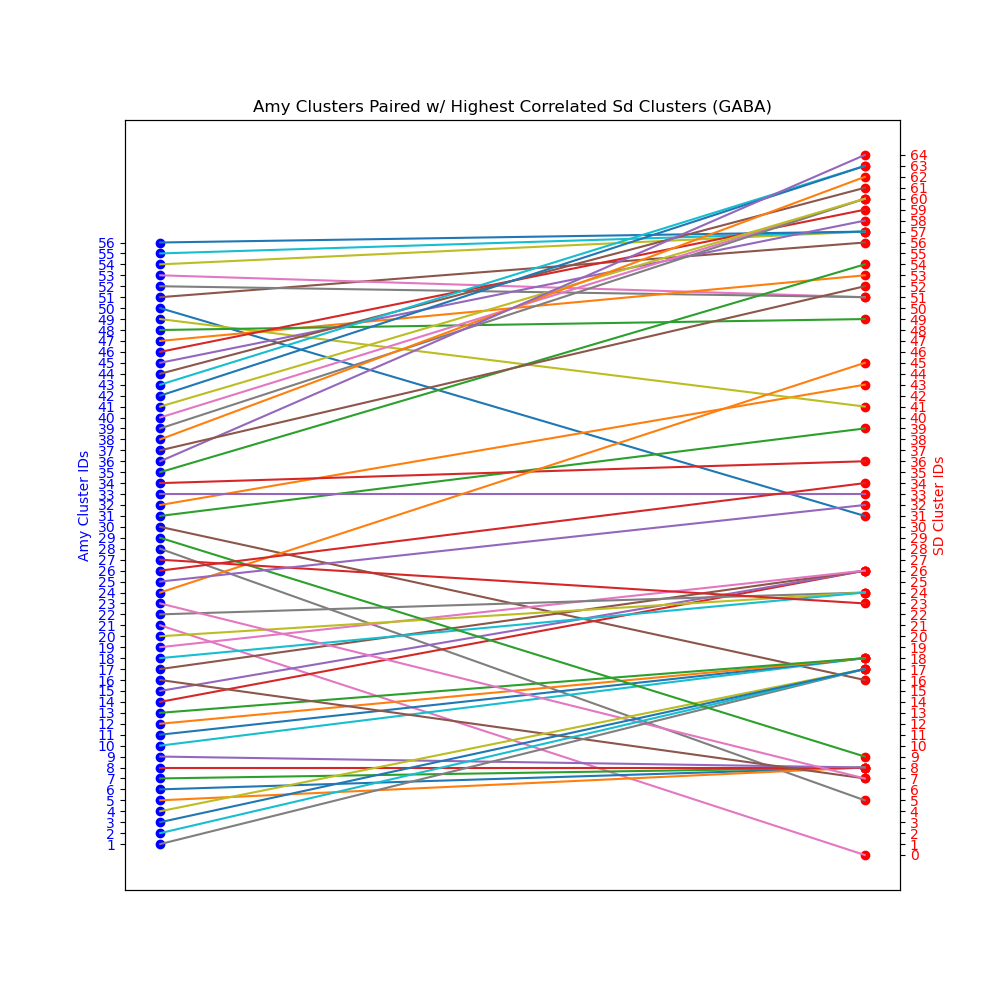

In [107]:
fig,ax1 = plt.subplots(figsize = (10,10))
ax1.set_title('Amy Clusters Paired w/ Highest Correlated Sd Clusters (GABA)')

ax2 = ax1.twinx()

x1 = np.zeros((1,len(connector_df_alt_lco['index'])))[0]
y1 = np.array(connector_df_alt_lco['index'])

x2 = np.ones((1,len(connector_df_alt_lco['corr_cluster'])))[0]
y2 = np.array(connector_df_alt_lco['corr_cluster'])

ax1.scatter(x = x1, 
            y = y1, color = 'b', label = 'amy_clusters')


ax1.set_yticks(np.sort(np.array(connector_df_alt_lco['index'])))
#plt.xticks([])
ax1.set_xticks([])
ax1.set_ylabel('Amy Cluster IDs', color = 'b')
ax1.tick_params(labelcolor = 'b')



ax1.scatter(x = x2, 
            y = y2, color = 'r', label = 'sd_clusters')

for i in range(len(connector_df_alt_lco)):
    plt.plot([x1[i], x2[i]], [y1[i], y2[i]], '-') 
    

#plt.ylabel('cluster_id')
#plt.yticks(np.arange(1,57))



ax2.set_yticks(np.arange(-1,np.max(np.array(connector_df_alt_lco['corr_cluster'])))+1)

ax2.set_ylabel('SD Cluster IDs', color = 'r')
ax2.tick_params(labelcolor = 'r')

#ax1.legend()
plt.savefig(folder+'gaba_connector_plot_amy_sd_lco_v2.png')
plt.show()

In [108]:
amy_metadata_df_gaba

,GGGTATTTCTCGCGTT-1_10-1,GGTAACTAGACATCCT-1_18-1,GGTAATCGTGGACTAG-1_18-1,TTCCGGTAGTGGTGGT-1_18-1,AGGGTGAAGTACAACA-1_19-1,AGTACCATCCCTGGTT-1_19-1,CATGAGTTCCGGCTTT-1_19-1,TTGCCTGAGACGGTTG-1_19-1,AAACGCTTCACCATGA-1_23-1,TACCCACCAGTGACCC-1_23-1,...,GTCAAACTCCCGATCT-1_76-2,GTGTAACGTGAGACCA-1_76-2,GTGTGATAGGTGAGAA-1_76-2,TACTTCAGTAACTAAG-1_76-2,TCCGATCTCGTTTACT-1_76-2,TCGCTCAAGATTGAGT-1_76-2,TGCAGGCTCTTACACT-1_76-2,TTACAGGTCCGAGATT-1_76-2,TTGCGTCCAACACGAG-1_76-2,TTGCTGCAGCACTCCG-1_76-2
celltype,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,GABA-11-Adora2a-Id4,...,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh,GABA-51-Vip-Crh
sample,10-1,18-1,18-1,18-1,19-1,19-1,19-1,19-1,23-1,23-1,...,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2,76-2
FC time,2,2,2,2,2,2,2,2,0,0,...,2,2,2,2,2,2,2,2,2,2
batch,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
cell_class,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,...,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA,GABA
cluster_label,11,11,11,11,11,11,11,11,11,11,...,51,51,51,51,51,51,51,51,51,51


In [114]:
'Crh' in amy_arr_gaba_expr_ge_cv_ls.index

True

In [115]:
amy_metadata_df_gaba.loc['celltype']

GGGTATTTCTCGCGTT-1_10-1    GABA-11-Adora2a-Id4
GGTAACTAGACATCCT-1_18-1    GABA-11-Adora2a-Id4
GGTAATCGTGGACTAG-1_18-1    GABA-11-Adora2a-Id4
TTCCGGTAGTGGTGGT-1_18-1    GABA-11-Adora2a-Id4
AGGGTGAAGTACAACA-1_19-1    GABA-11-Adora2a-Id4
                                  ...         
TCGCTCAAGATTGAGT-1_76-2        GABA-51-Vip-Crh
TGCAGGCTCTTACACT-1_76-2        GABA-51-Vip-Crh
TTACAGGTCCGAGATT-1_76-2        GABA-51-Vip-Crh
TTGCGTCCAACACGAG-1_76-2        GABA-51-Vip-Crh
TTGCTGCAGCACTCCG-1_76-2        GABA-51-Vip-Crh
Name: celltype, Length: 13006, dtype: object

In [ ]:
#in amy metadata, extract markers and organize s/t each cluster ID has associated markers
#check to see if connected sd_cluster also shows high marker avg expr
#replot connector w/ cluster markers instead of cluster ids

[['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 

In [573]:
###################old/backup/scratch###################

### corrwith() vs. corr() example

In [584]:
np.random.seed(5)
index = ["g1", "g2", "g3", "g4", "g5"]
columns = ["one", "two", "three", "four","five"]
df1 = pd.DataFrame(np.random.rand(5,5), index=index, columns=columns)
df2 = pd.DataFrame(np.random.rand(5,4), index=index, columns=columns[:4])


In [585]:
df1

,one,two,three,four,five
g1,0.221993,0.870732,0.206719,0.918611,0.488411
g2,0.611744,0.765908,0.518418,0.296801,0.187721
g3,0.080741,0.738440,0.441309,0.158310,0.879937
g4,0.274086,0.414235,0.296080,0.628788,0.579838
g5,0.599929,0.265819,0.284686,0.253588,0.327564


In [586]:
df2

,one,two,three,four
g1,0.144164,0.165613,0.963931,0.960227
g2,0.188415,0.024307,0.204556,0.699844
g3,0.779515,0.022933,0.577663,0.001642
g4,0.515473,0.639795,0.985624,0.259098
g5,0.802497,0.870483,0.922750,0.002214


In [587]:
df1.corrwith(df2, axis=0)

one     -0.122051
two     -0.942317
three   -0.946490
four     0.710635
five          NaN
dtype: float64

In [588]:
pd.concat([df1, df2],axis=1).corr()

,one,two,three,four,five,one,two,three,four
one,1.000000,-0.402054,0.212745,-0.281101,-0.924940,-0.122051,0.365828,-0.304699,0.063459
two,-0.402054,1.000000,0.257426,0.287125,0.150378,-0.658193,-0.942317,-0.450567,0.691083
three,0.212745,0.257426,1.000000,-0.726333,-0.069552,0.021379,-0.548253,-0.946490,-0.149437
four,-0.281101,0.287125,-0.726333,1.000000,-0.060772,-0.649870,0.017370,0.568173,0.710635
five,-0.924940,0.150378,-0.069552,-0.060772,1.000000,0.472897,-0.213327,0.254671,-0.429568
one,-0.122051,-0.658193,0.021379,-0.649870,0.472897,1.000000,0.488051,0.236740,-0.979477
two,0.365828,-0.942317,-0.548253,0.017370,-0.213327,0.488051,1.000000,0.672052,-0.478168
three,-0.304699,-0.450567,-0.946490,0.568173,0.254671,0.236740,0.672052,1.000000,-0.135005
four,0.063459,0.691083,-0.149437,0.710635,-0.429568,-0.979477,-0.478168,-0.135005,1.000000


In [612]:

# Initialize an empty dataframe to hold the correlation coefficients
correlation_matrix_chat = pd.DataFrame(index=df1.columns, columns=df2.columns)

# Compute the correlation coefficients
for col1 in df1.columns:
    for col2 in df2.columns:
        correlation_matrix_chat.loc[col1, col2] = df1[col1].corr(df2[col2])

In [613]:
correlation_matrix_chat

,one,two,three,four
one,-0.122051,0.365828,-0.304699,0.063459
two,-0.658193,-0.942317,-0.450567,0.691083
three,0.021379,-0.548253,-0.94649,-0.149437
four,-0.64987,0.01737,0.568173,0.710635
five,0.472897,-0.213327,0.254671,-0.429568


In [472]:
np.random.rand(4,4)

array([[0.64974906, 0.24880237, 0.36565569, 0.47207162],
       [0.25539014, 0.61145039, 0.42194013, 0.89595233],
       [0.67309502, 0.01799882, 0.57259172, 0.51005648],
       [0.26610062, 0.63002322, 0.90600956, 0.26364928]])

In [45]:
with open('/bigdata/isaac/gaba_files/gaba_cl_mg_dict2024-06-07.json') as json_data:
    gaba_cl_mg_dict = json.load(json_data)

In [46]:
gaba_cl_mg_dict

{'31': ['Chat',
  'Matn2',
  'Slc10a4',
  'Th',
  'Zic1',
  'Hspb8',
  'Lhx8',
  'Nkx2-1',
  'Pbx3',
  'Deptor',
  'Ndrg1',
  'Isl1',
  'Ntrk1',
  'Trap1a',
  'Ngfr',
  'Slc5a7',
  'Slc18a3'],
 '12': ['Prok2',
  'Pdyn',
  'Esr1',
  'Map3k15',
  'Nptx2',
  'Dkk2',
  'Cd68',
  'Prdm13',
  'Wfs1',
  'Rbp1',
  'Hs3st6',
  'Creb3l1',
  'Fbn2'],
 '42': ['Tmem100',
  'Arpp21',
  'Brinp3',
  'Cartpt',
  'Pappa',
  'Dkk3',
  'Rcn1',
  'C1ql1'],
 '43': ['Phxr4', 'Crtac1', 'Tmem26', 'Jsrp1', 'Ddc', 'Unc13c', 'Clca3a1'],
 '40': ['Apoc3', 'Rprm', 'Igfbp6'],
 '39': ['Slc35d3', 'Cck', 'Grp', 'Bmpr1b'],
 '36': ['Prlr', 'Plagl1', 'Cbln1', 'Pde1c', 'Ramp3', 'Ppp1r17', 'Cckar'],
 '55': ['Kcng2',
  'Chst8',
  'Gpd1',
  'Gm17660',
  'St18',
  'Klhl14',
  'Defb1',
  'Gm28884',
  'Fam159b',
  'Brs3'],
 '65': ['Phgdh'],
 '33': [],
 '16': ['Calcr', 'Myl4', 'Gpc3'],
 '38': ['Jun', 'Gm5141', 'Pgr15l'],
 '2': ['Col18a1'],
 '20': ['Lamb3', 'Greb1'],
 '35': ['Msn'],
 '0': ['Gpr101', 'Brinp1'],
 '14': ['Nrgn', 'Dnah

In [61]:
gaba_cl_mg_dict['31']

['Chat',
 'Matn2',
 'Slc10a4',
 'Th',
 'Zic1',
 'Hspb8',
 'Lhx8',
 'Nkx2-1',
 'Pbx3',
 'Deptor',
 'Ndrg1',
 'Isl1',
 'Ntrk1',
 'Trap1a',
 'Ngfr',
 'Slc5a7',
 'Slc18a3']

In [40]:
gaba_df_marker_log_and_std.index[:18]

Index(['Chat', 'Matn2', 'Slc10a4', 'Th', 'Zic1', 'Hspb8', 'Lhx8', 'Nkx2-1',
       'Pbx3', 'Deptor', 'Ndrg1', 'Isl1', 'Ntrk1', 'Trap1a', 'Ngfr', 'Slc5a7',
       'Slc18a3', 'Prok2'],
      dtype='object', name='gene')

In [47]:
gaba_df_marker_log_and_std.shape

(324, 13529)

In [50]:
gaba_df_marker

,GCAGCTGTCCCGTTGT-1_10X52_1,GGGTCACGTGCCGTTG-1_10X36_1,CCGCAAGGTGTTATCG-1_10X36_1,ACTACGAGTCCACTCT-1_10X37_1,AAGATAGGTAACACCT-1_10X37_2,GATGAGGGTATAATGG-1_10X52_2,CAACAACAGACATATG-1_10X35_2,GATAGCTGTAACGCGA-1_10X36_2,ACACCAATCTACCCAC-1_10X52_2,GCAACATAGATCGACG-1_10X51_2,...,ACTACGAAGCGATGAC-1_10X35_1,GGCACGTAGAGAGCAA-1_10X36_1,ATTACTCAGGTGAGAA-1_10X38_1,CATCGGGGTGTTCCTC-1_10X38_1,GAGGCCTAGCGTATGG-1_10X37_1,TCCACGTCATCCTTGC-1_10X36_1,TAGGTACTCACGGGAA-1_10X35_2,TAACCAGGTACAGGTG-1_10X51_1,CAAGAGGTCCTACAAG-1_10X35_2,TTCCGGTAGATAACGT-1_10X51_4
gene,,,,,,,,,,,,,,,,,,,,,
Chat,1,0,25,0,10,0,6,0,4,0,...,0,0,0,0,0,0,0,0,0,0
Matn2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Slc10a4,0,6,49,0,33,1,7,0,5,2,...,0,0,0,0,0,0,0,0,0,0
Th,0,0,2,0,0,0,0,0,7,0,...,0,0,0,0,0,0,0,0,0,0
Zic1,9,2,46,0,15,0,5,6,4,5,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ccdc109b,0,0,1,0,2,1,0,0,1,0,...,0,0,0,1,2,0,0,0,1,0
Npy,0,0,0,0,0,0,0,0,0,0,...,13,4,7,32,230,217,79,141,229,91
Gcnt1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,2,3,0,3,0,0


In [167]:
gaba_meta_data_df_plis

,GCAGCTGTCCCGTTGT-1_10X52_1,GGGTCACGTGCCGTTG-1_10X36_1,CCGCAAGGTGTTATCG-1_10X36_1,ACTACGAGTCCACTCT-1_10X37_1,AAGATAGGTAACACCT-1_10X37_2,GATGAGGGTATAATGG-1_10X52_2,CAACAACAGACATATG-1_10X35_2,GATAGCTGTAACGCGA-1_10X36_2,ACACCAATCTACCCAC-1_10X52_2,GCAACATAGATCGACG-1_10X51_2,...,ACTACGAAGCGATGAC-1_10X35_1,GGCACGTAGAGAGCAA-1_10X36_1,ATTACTCAGGTGAGAA-1_10X38_1,CATCGGGGTGTTCCTC-1_10X38_1,GAGGCCTAGCGTATGG-1_10X37_1,TCCACGTCATCCTTGC-1_10X36_1,TAGGTACTCACGGGAA-1_10X35_2,TAACCAGGTACAGGTG-1_10X51_1,CAAGAGGTCCTACAAG-1_10X35_2,TTCCGGTAGATAACGT-1_10X51_4
Serial_Number,101.0,65.0,65.0,67.0,68.0,102.0,64.0,66.0,102.0,98.0,...,63.0,65.0,69.0,69.0,67.0,65.0,64.0,97.0,64.0,100.0
Date_Captured,05/31/20,2019-11-24,2019-11-24,2019-11-25,2019-11-25,05/31/20,2019-11-20,2019-11-24,05/31/20,05/31/20,...,2019-11-20,2019-11-24,2019-12-01,2019-12-01,2019-11-25,2019-11-24,2019-11-20,05/31/20,2019-11-20,05/31/20
Species,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,...,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm
Transcriptome,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,...,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10
Strain,C57Bl/6,,,,,C57Bl/6,,,C57Bl/6,C57Bl/6,...,,,,,,,,C57Bl/6,,C57Bl/6
Project,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,...,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph
Group,Breeder-F,Naïve-M,Naïve-M,Naïve-M,Naïve-M,Breeder-F,Naïve-F,Naïve-M,Breeder-F,Breeder-F,...,Naïve-F,Naïve-M,Naïve-F,Naïve-F,Naïve-M,Naïve-M,Naïve-F,Breeder-F,Naïve-F,Breeder-M
ChipID,10X52,10X36,10X36,10X37,10X37,10X52,10X35,10X36,10X52,10X51,...,10X35,10X36,10X38,10X38,10X37,10X36,10X35,10X51,10X35,10X51
SampleID,10X52_1,10X36_1,10X36_1,10X37_1,10X37_2,10X52_2,10X35_2,10X36_2,10X52_2,10X51_2,...,10X35_1,10X36_1,10X38_1,10X38_1,10X37_1,10X36_1,10X35_2,10X51_1,10X35_2,10X51_4
DonorID,DI-B3-F,DI3,DI3,"DI4,DI5","DI4,DI5",DI-B3-F,"DI1,DI2",DI3,DI-B3-F,DI-B1-F,...,"DI1,DI2",DI3,DI6,DI6,"DI4,DI5",DI3,"DI1,DI2",DI-B1-F,"DI1,DI2",DI-B1-M


In [93]:
gaba_mean_marker_per_cluster = pd.DataFrame(columns=['gene', 'avg_expr','cluster_id'])
for k,v in gaba_cl_mg_dict.items():
    #print (k,v)
    tmp_df = pd.DataFrame({'gene':gaba_cl_mg_dict[k],
                           'avg_expr':np.array(gaba_df_marker.loc[gaba_cl_mg_dict[k],gaba_df_marker.iloc[:,np.where(gaba_meta_data_df_plis.loc['cluster_label']==int(k))[0]].columns].mean(axis=1)), 
                           'cluster_id':np.array(int(k)*np.ones(len(gaba_cl_mg_dict[k])))})
    gaba_mean_marker_per_cluster = pd.concat([gaba_mean_marker_per_cluster, tmp_df])

gaba_mean_marker_per_cluster

/tmp/ipykernel_2445590/3401018307.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gaba_mean_marker_per_cluster = pd.concat([gaba_mean_marker_per_cluster, tmp_df])


,gene,avg_expr,cluster_id
0,Chat,4.142857,31.0
1,Matn2,0.250000,31.0
2,Slc10a4,8.357143,31.0
3,Th,1.607143,31.0
4,Zic1,6.964286,31.0
...,...,...,...
2,Mpped1,3.461957,63.0
3,Tmem132c,1.076087,63.0
4,Gpr83,3.277174,63.0
5,Moxd1,3.320652,63.0


In [59]:
np.where(gaba_meta_data_df_plis.loc['cluster_label']==31)[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [98]:
gaba_cl_mg_dict['63']

['Efcab6', '3110035E14Rik', 'Mpped1', 'Tmem132c', 'Gpr83', 'Moxd1']

In [112]:
def compute_class_marker_mean(df,meta_data_df,cl_mg_dict):
    '''
    For level 2 analysis. Computes average expression of each marker gene for a specific cell class (e.g. gaba)                  
    ----------------------------------------------------------------------
    Parameters

    df: pandas.core.frame.DataFrame
        marker gene expression dataframe of a single cell class
    meta_data_df: pandas.core.frame.DataFrame
        gene expression metadata corresponding to df
    cl_mg_dict: pandas.core.frame.DataFrame
        2D input array, typically output from tsne, in dataframe format
    ----------------------------------------------------------------------
    Returns
    mean_marker_per_cluster: pandas.core.frame.DataFrame
        dataframe storing marker gene, avg expression, and cluster ID
    '''
    mean_marker_per_cluster = pd.DataFrame(columns=['gene', 'avg_expr','cluster_id'])
    for k,v in cl_mg_dict.items():
        #print (k,v)
        tmp_df = pd.DataFrame({'gene':cl_mg_dict[k],
                               'avg_expr':np.array(df.loc[cl_mg_dict[k],df.iloc[:,np.where(meta_data_df.loc['cluster_label']==int(k))[0]].columns].mean(axis=1)), 
                               'cluster_id':np.array(int(k)*np.ones(len(cl_mg_dict[k])))})
        
        #print (tmp_df.head())
        mean_marker_per_cluster = pd.concat([mean_marker_per_cluster, tmp_df])

    return mean_marker_per_cluster 

In [113]:
gaba_mean_marker_per_cluster = compute_class_marker_mean(gaba_df_marker, gaba_meta_data_df_plis, gaba_cl_mg_dict)

/tmp/ipykernel_2445590/2024660757.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mean_marker_per_cluster = pd.concat([mean_marker_per_cluster, tmp_df])


In [114]:
gaba_mean_marker_per_cluster

,gene,avg_expr,cluster_id
0,Chat,4.142857,31.0
1,Matn2,0.250000,31.0
2,Slc10a4,8.357143,31.0
3,Th,1.607143,31.0
4,Zic1,6.964286,31.0
...,...,...,...
2,Mpped1,3.461957,63.0
3,Tmem132c,1.076087,63.0
4,Gpr83,3.277174,63.0
5,Moxd1,3.320652,63.0
